In [5]:
import torch
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from tqdm import tqdm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import math

In [6]:
train_embeddings = torch.load('./SMAI_A1/train_embeddings.pth', weights_only=True)
train_labels = torch.load('./SMAI_A1/train_labels.pth', weights_only=True)
print(train_embeddings.shape, train_labels.shape)

torch.Size([50000, 512]) torch.Size([50000])


In [7]:
test_embeddings = torch.load('./SMAI_A1/test_embeddings.pth', weights_only=True)
test_labels = torch.load('./SMAI_A1/test_labels.pth', weights_only=True)
print(test_embeddings.shape, test_labels.shape)

torch.Size([10000, 512]) torch.Size([10000])


In [8]:
text_embeddings = torch.load('./SMAI_A1/text_embedding.pth', map_location=torch.device('cpu'), weights_only=True)
print(text_embeddings.shape)
text_labels = torch.tensor(range(10))

torch.Size([10, 512])


In [21]:

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

class LSHKNNRetrievalModel():
    def __init__(self, train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', num_hyperplanes=1):
        self.train_embeddings = train_embeddings.cpu().numpy()
        self.test_embeddings = test_embeddings.cpu().numpy()
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.k = k
        self.distance_metric = distance_metric  
        self.num_hyperplanes = num_hyperplanes
        self.hash_tables = {}
        self.distance_matrix = None
        self.hyperplanes = self.generate_random_hyperplanes()
        self.create_hash_buckets()
    def compute_distance_matrix(self):
        if self.distance_metric == 'cosine':
            self.distance_matrix = cosine_distances(self.test_embeddings, self.train_embeddings)
        elif self.distance_metric == 'euclidean':
            self.distance_matrix = euclidean_distances(self.test_embeddings, self.train_embeddings)
    def generate_random_hyperplanes(self):
        return np.random.randn(self.num_hyperplanes, self.train_embeddings.shape[1])
    
    def hash_embedding(self, embedding):
        return tuple((np.dot(embedding, self.hyperplanes.T) > 0).astype(int))
    
    def create_hash_buckets(self):
        self.hash_tables = {}
        for i in range(len(self.train_embeddings)):
            hash_key = self.hash_embedding(self.train_embeddings[i])
            if hash_key not in self.hash_tables:
                self.hash_tables[hash_key] = []
            self.hash_tables[hash_key].append((i, self.train_embeddings[i]))
     
    def plot_bucket_histogram(self):
        bucket_sizes = [len(self.hash_tables[key]) for key in self.hash_tables]
        plt.hist(bucket_sizes, bins=20, alpha=0.75, color='b', edgecolor='black')
        plt.xlabel('Bucket Size')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Bucket Sizes with {self.num_hyperplanes} Hyperplanes')
        plt.show()
    
    
    def retrieve_candidates(self, idx, query_embedding, find_num_cands=0):
        hash_key = self.hash_embedding(query_embedding)
        candidates = self.hash_tables.get(hash_key, [])
        if find_num_cands:
            return len(candidates)
        if len(candidates) >= self.k:
            ranked_candidates = sorted(candidates,key=lambda candidate: self.distance_matrix[idx][candidate[0]])
            return ranked_candidates[:self.k]
        sorted_keys = sorted(self.hash_tables.keys(),key=lambda key: np.linalg.norm(np.array(key) - np.array(hash_key)))
        for key in sorted_keys:
            if key != hash_key:
                candidates.extend(self.hash_tables[key])
                if len(candidates) >= self.k:
                    break
        ranked_candidates = sorted(candidates, key=lambda candidate: self.distance_matrix[idx][candidate[0]])
        return ranked_candidates[:self.k]

    def evaluate(self):
        self.compute_distance_matrix()
        MRR = 0
        Precision = 0
        HR = 0
        for i in tqdm(range(len(self.test_embeddings))):
            retrieved_candidates = self.retrieve_candidates(i, self.test_embeddings[i])
            retrieved_indices = [candidate[0] for candidate in retrieved_candidates]
            possible_labels = [self.train_labels[int(index)] for index in retrieved_indices]
            for j in range(len(possible_labels)):
                if possible_labels[j] == int(self.test_labels[i]):
                    MRR += (1 / (j + 1))
                    HR += 1
                    break
            for j in range(len(possible_labels)):
                if possible_labels[j] == int(self.test_labels[i]):
                    Precision += 1 / 100
        
        print(f'Results for {self.distance_metric} distance and k = {self.k} with {self.num_hyperplanes} hyperplanes:')
        print(f'Mean Reciprocal Rank: {MRR / len(self.test_embeddings)}')
        print(f'Precision@100: {Precision / len(self.test_embeddings)}')
        print(f'Hit Rate: {HR / len(self.test_embeddings)}')

num_hps = [1, 5, 10]  

100%|██████████| 10000/10000 [03:19<00:00, 50.01it/s]


Results for cosine distance and k = 10 with 1 hyperplanes:
Mean Reciprocal Rank: 0.9326096031746036
Precision@100: 0.08715099999993524
Hit Rate: 0.9862


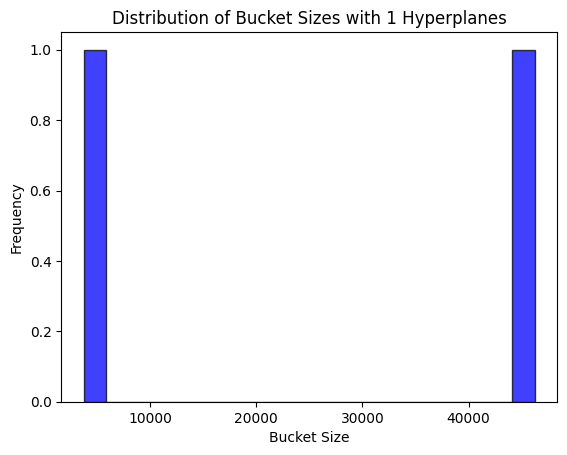

100%|██████████| 10000/10000 [00:32<00:00, 312.37it/s]


Results for cosine distance and k = 10 with 5 hyperplanes:
Mean Reciprocal Rank: 0.921199246031747
Precision@100: 0.08471199999993746
Hit Rate: 0.9808


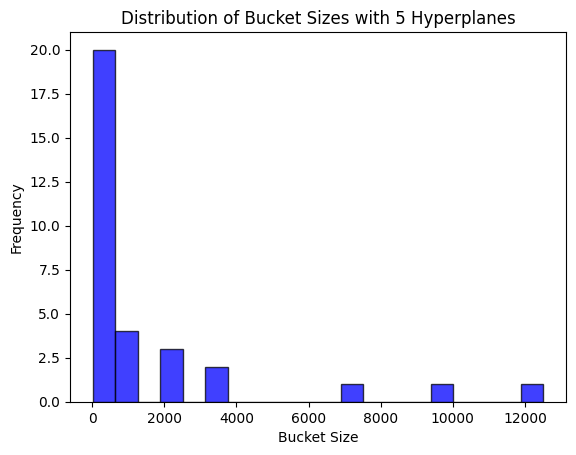

100%|██████████| 10000/10000 [00:14<00:00, 704.71it/s]


Results for cosine distance and k = 10 with 10 hyperplanes:
Mean Reciprocal Rank: 0.9098717857142854
Precision@100: 0.08311099999993891
Hit Rate: 0.9775


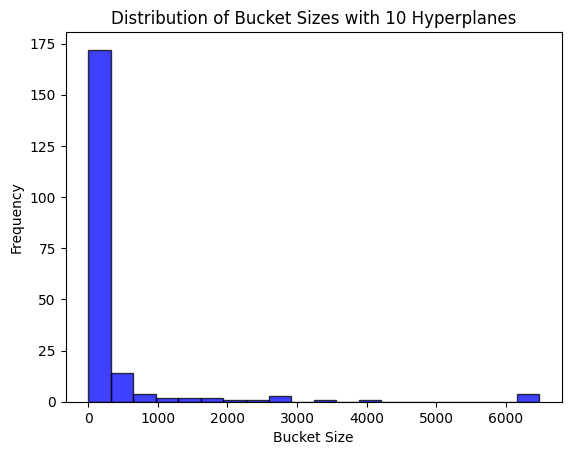

100%|██████████| 10000/10000 [03:52<00:00, 43.04it/s]


Results for cosine distance and k = 50 with 1 hyperplanes:
Mean Reciprocal Rank: 0.9346716536926164
Precision@100: 0.4260030000046566
Hit Rate: 0.9982


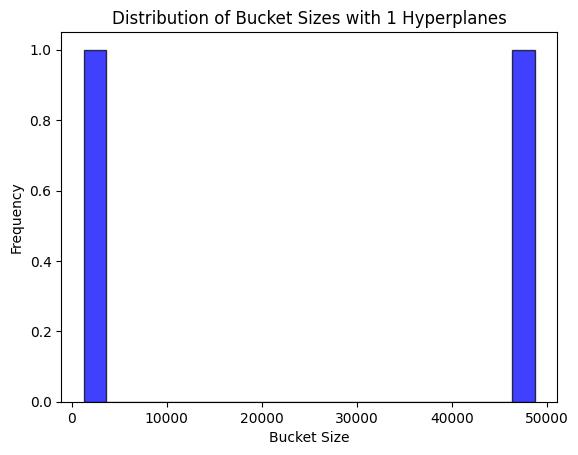

100%|██████████| 10000/10000 [00:32<00:00, 309.62it/s]


Results for cosine distance and k = 50 with 5 hyperplanes:
Mean Reciprocal Rank: 0.91713103475425
Precision@100: 0.39872100000406113
Hit Rate: 0.9968


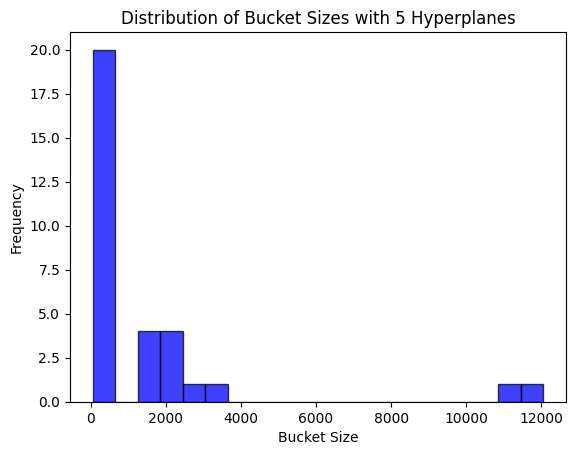

100%|██████████| 10000/10000 [00:14<00:00, 672.50it/s]


Results for cosine distance and k = 50 with 10 hyperplanes:
Mean Reciprocal Rank: 0.9080296773814455
Precision@100: 0.3728580000034966
Hit Rate: 0.9934


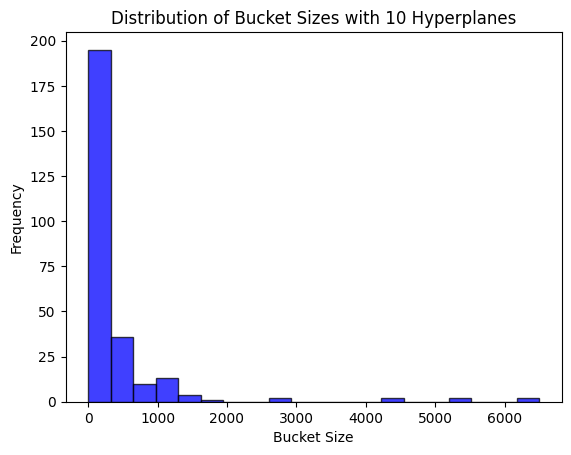

100%|██████████| 10000/10000 [03:00<00:00, 55.33it/s]


Results for cosine distance and k = 100 with 1 hyperplanes:
Mean Reciprocal Rank: 0.9318314744712787
Precision@100: 0.830462000013485
Hit Rate: 0.9993


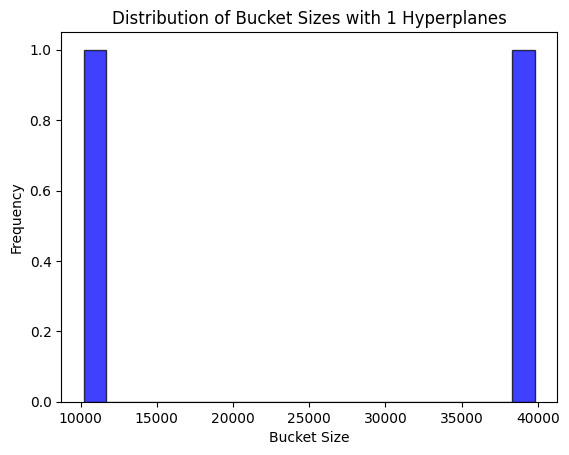

100%|██████████| 10000/10000 [01:08<00:00, 146.29it/s]


Results for cosine distance and k = 100 with 5 hyperplanes:
Mean Reciprocal Rank: 0.9204431694631298
Precision@100: 0.7881540000125615
Hit Rate: 0.9986


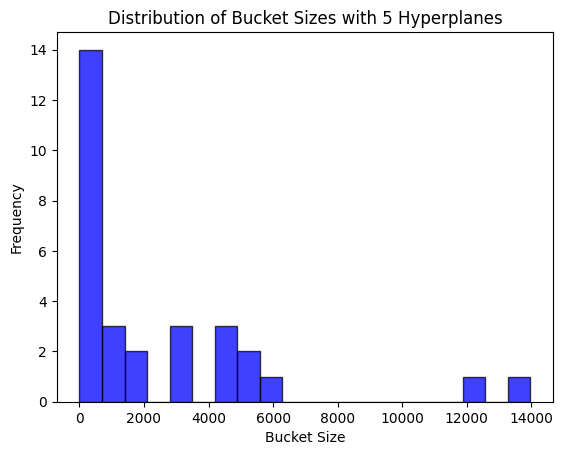

100%|██████████| 10000/10000 [00:34<00:00, 289.62it/s]


Results for cosine distance and k = 100 with 10 hyperplanes:
Mean Reciprocal Rank: 0.9181952708013483
Precision@100: 0.7594610000119353
Hit Rate: 0.9988


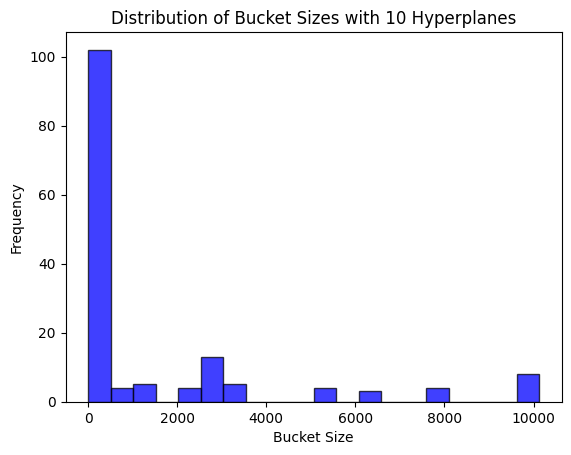

In [120]:

ks = [10, 50, 100]   
for k in ks:
    for n in num_hps: 
        model = LSHKNNRetrievalModel(train_embeddings, test_embeddings, train_labels, test_labels, k=k, distance_metric='cosine', num_hyperplanes=n)                                                                                                                                                                                                    
        model.evaluate()
        model.plot_bucket_histogram()
        del model

In [25]:
for n in num_hps:
    model = LSHKNNRetrievalModel(train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', num_hyperplanes=n)
    total_comparisons = 0
    for i in tqdm(range(len(model.test_embeddings))):
        total_comparisons += model.retrieve_candidates(i, model.test_embeddings[i], find_num_cands=1)
    avg_comparisons = total_comparisons / len(model.test_embeddings)
    print(f"{n}: {avg_comparisons}")

100%|██████████| 10000/10000 [00:00<00:00, 59763.41it/s]


1: 37085.546


100%|██████████| 10000/10000 [00:00<00:00, 64345.61it/s]


5: 7882.5287


100%|██████████| 10000/10000 [00:00<00:00, 48501.62it/s]

10: 4204.3249
